In [16]:
# 📌 1. Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [17]:
# 📌 2. Data Directory & Augmentation
data_dir = "/content/dataset/DataSet/DataSet"  # Change path if needed

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
print("Classes:", class_names)


Classes: ['Data_cloudy', 'Data_desert', 'Data_green_area', 'Data_water']


In [18]:
# 📌 3. Data Splitting
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)


In [19]:
# 📌 4. Load Pretrained VGG19 and Modify
model = models.vgg19(pretrained=True)

# Freeze base layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier for 4 classes
model.classifier[6] = nn.Linear(in_features=4096, out_features=4)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 153MB/s]


In [20]:
# 📌 5. Loss, Optimizer, etc.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [22]:
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(3):  # 🔁 Changed from 10 to 3 epochs
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    train_acc = 100 * correct / total
    train_loss_list.append(train_loss / len(train_loader))
    train_acc_list.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

    val_acc = 100 * correct / total
    val_loss_list.append(val_loss / len(val_loader))
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/3 | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


Epoch 1/3 | Train Acc: 87.06% | Val Acc: 93.33%
Epoch 2/3 | Train Acc: 92.54% | Val Acc: 94.07%
Epoch 3/3 | Train Acc: 93.41% | Val Acc: 87.04%


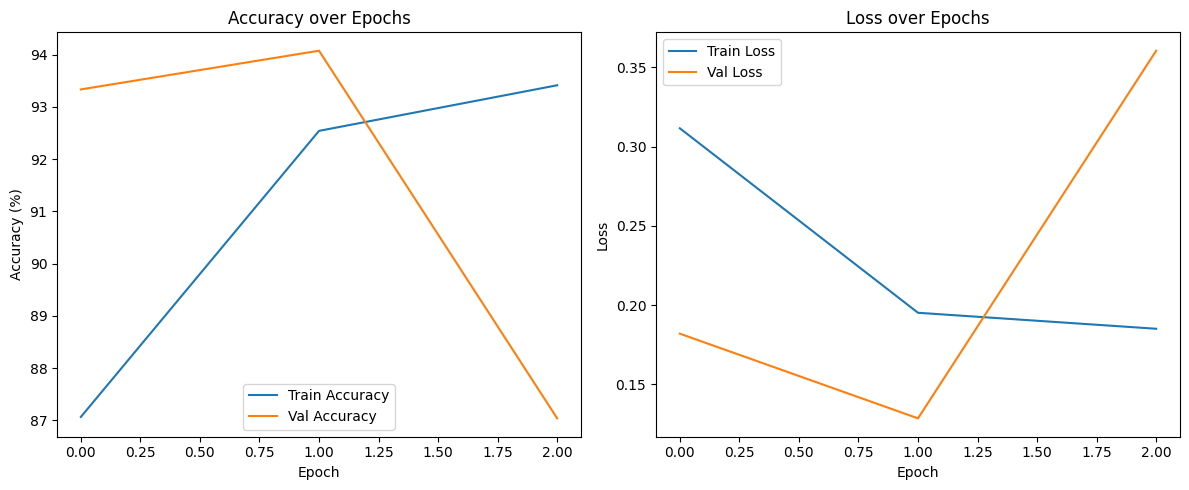

In [23]:
# 📌 7. Accuracy & Loss Graphs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy over Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs")

plt.tight_layout()
plt.show()


In [24]:
# 📌 8. Test Evaluation & Metrics
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))


                 precision    recall  f1-score   support

    Data_cloudy       1.00      0.72      0.84        72
    Data_desert       0.81      1.00      0.89        75
Data_green_area       0.93      1.00      0.97        71
     Data_water       0.96      0.90      0.93        52

       accuracy                           0.91       270
      macro avg       0.92      0.91      0.91       270
   weighted avg       0.92      0.91      0.90       270



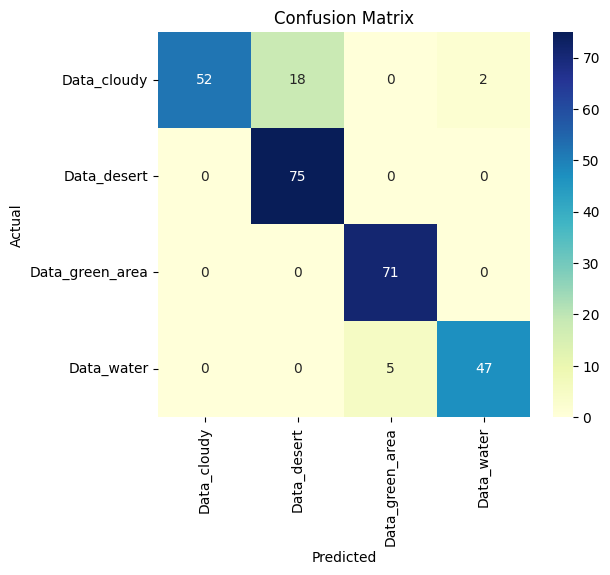

Specificity for class 'Data_cloudy': 1.00
Specificity for class 'Data_desert': 0.91
Specificity for class 'Data_green_area': 0.97
Specificity for class 'Data_water': 0.99


In [25]:
# 📌 9. Confusion Matrix + Specificity
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='YlGnBu')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Specificity
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (TP + FP + FN)

specificity = TN / (TN + FP)
for i, spec in enumerate(specificity):
    print(f"Specificity for class '{class_names[i]}': {spec:.2f}")
